### Dirichlet Mixture Priors

Train dirichlet mixture priors by maximizing the likelihood of probability distributions from reference alignments given the parameters of the prior.

In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import itertools
from learnMSA import msa_hmm

### Training

Here we train directly on the multinomial distributions taken from Pfam

In [2]:
PFAM_A_FILEPATH = "../old/Pfam/Pfam-A.hmm"
match_dists = []
insert_dists = []
delete_dists = []
emission_dists = []
sample_weights = []
with open(PFAM_A_FILEPATH, "r") as hmm_file:
    hmms = hmm_file.read().split("//")
    hmms = [hmm.strip() for hmm in hmms]
    hmms = [hmm for hmm in hmms if len(hmm) > 0]
    for hmm in hmms:
        hmm_lines = hmm.split("\n")
        hmm_start = -1
        for i,l in enumerate(hmm_lines):
            if l[:4] == "HMM ":
                hmm_start = i
                hmm_alphabet = l.split()[1:]
                perm = [hmm_alphabet.index(aa) for aa in msa_hmm.fasta.alphabet[:20]]
                break
        dists = hmm_lines[hmm_start+7:][::3]     
        em_dists = hmm_lines[hmm_start+5:][::3]        
        for d in dists:
            d_float = [0 if p=="*" else np.exp(-float(p)) for p in d.split()]
            match_dists.append(np.array(d_float[:3]))
            insert_dists.append(np.array(d_float[3:5]))
            delete_dists.append(np.array(d_float[5:]))
        for d in em_dists[:-1]:
            d_float = [0 if p=="*" else np.exp(-float(p)) for p in d.split()[1:21]]
            emission_dists.append(np.array(d_float))
            emission_dists[-1] = emission_dists[-1][perm]
        num_cols = len(em_dists)-1
        sample_weights.append(np.ones(num_cols) / (num_cols * len(hmms)))
match_dists = [d for d in match_dists if np.all(d>0)]
insert_dists = [d for d in insert_dists if np.all(d>0)]
delete_dists = [d for d in delete_dists if np.all(d>0)]
emission_dists = [d for d in emission_dists if np.all(d>0)]
match_dists = np.stack(match_dists)
insert_dists = np.stack(insert_dists)
delete_dists = np.stack(delete_dists)
emission_dists = np.stack(emission_dists)
sample_weights = np.concatenate(sample_weights, axis=0)
print(match_dists.shape)
print(insert_dists.shape)
print(delete_dists.shape)
print(emission_dists.shape)
print(sample_weights.shape) #unused
np.random.shuffle(match_dists)
np.random.shuffle(insert_dists)
np.random.shuffle(delete_dists)
np.random.shuffle(emission_dists)

(3239607, 3)
(3258786, 2)
(3239607, 2)
(3239607, 20)
(3239607,)


In [4]:
def split_train_test(data, frag_test=0.15):
    num_train = int(data.shape[0] * (1-frag_test))
    training, test = data[:num_train,:], data[num_train:,:]
    return training, test

match_dists_train, match_dists_test = split_train_test(match_dists)
insert_dists_train, insert_dists_test = split_train_test(insert_dists)
delete_dists_train, delete_dists_test = split_train_test(delete_dists)
emission_dists_train, emission_dists_test = split_train_test(emission_dists)

### Dirichlet mixture for match positions

In [4]:
learn_msa_dir = "../learnMSA/"
prior_dir = learn_msa_dir + "/learnMSA/msa_hmm/trained_prior/"

In [ ]:
background_init_default = np.log([0.08561094, 0.05293611, 0.04151133, 0.05672544, 0.01636436,
       0.03728793, 0.06006028, 0.08408517, 0.0247461 , 0.06263597,
       0.09096471, 0.05326487, 0.02224342, 0.03875183, 0.04393068,
       0.05451456, 0.05665095, 0.01439066, 0.03299227, 0.07033241])

component_counts = [1,3,9,32,64,128,256]
runs = 5
configs = itertools.product(component_counts, [True, False], [tf.float32, tf.float64])
with open(prior_dir+"emissions.log", "a") as file:
    for k, use_dirichlet_process, dtype  in configs:
        models = []
        for i in range(runs):
            optimizer = tf.optimizers.Adam(1e-2)
            background_init = tf.constant_initializer(background_init_default)
            print(k, use_dirichlet_process, dtype)
            dm_layer = msa_hmm.dm.DirichletMixtureLayer(num_components = k,
                                                        alphabet_size = emission_dists.shape[-1], 
                                                        use_dirichlet_process = use_dirichlet_process, 
                                                        number_of_examples = emission_dists.shape[0],
                                                        alpha_init = "ones",
                                                        mix_init = "random_normal",
                                                        background_init = background_init)
            model = msa_hmm.dm.make_model(dm_layer)
            model.compile(optimizer)
            callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                        patience=2, 
                                                        restore_best_weights=True)
            batch_size = 512
            history = model.fit(emission_dists_train, 
                                epochs = 1000, 
                                verbose = 1, 
                                batch_size=batch_size, 
                                shuffle=True,
                                callbacks=[callback])
            loglik = tf.reduce_mean(model.predict(emission_dists_test, batch_size=batch_size)).numpy()
            file.write(f"Fitted a model for k = {k} with loglik = {loglik} \n")
            file.flush()
            models.append((loglik, model))

        best = max(models)
        file.write(f"Saving best model for k = {k} with loglik = {best[0]} to file \n")
        file.flush()
        model_name = "_".join([str(k), str(use_dirichlet_process), dtype.name, "_dirichlet/ckpt"])
        best[1].save_weights(prior_dir + model_name)

        tf.keras.backend.clear_session()

### Load a prior and check its components

In [43]:
num_components = 9
use_dirichlet_process = True
dtype = tf.float32
model_path = prior_dir + "_".join([str(num_components), str(use_dirichlet_process), dtype.name, "_dirichlet/ckpt"])
model = msa_hmm.dm.load_mixture_model(model_path, num_components, 20)
dirichlet_layer = model.layers[-1]

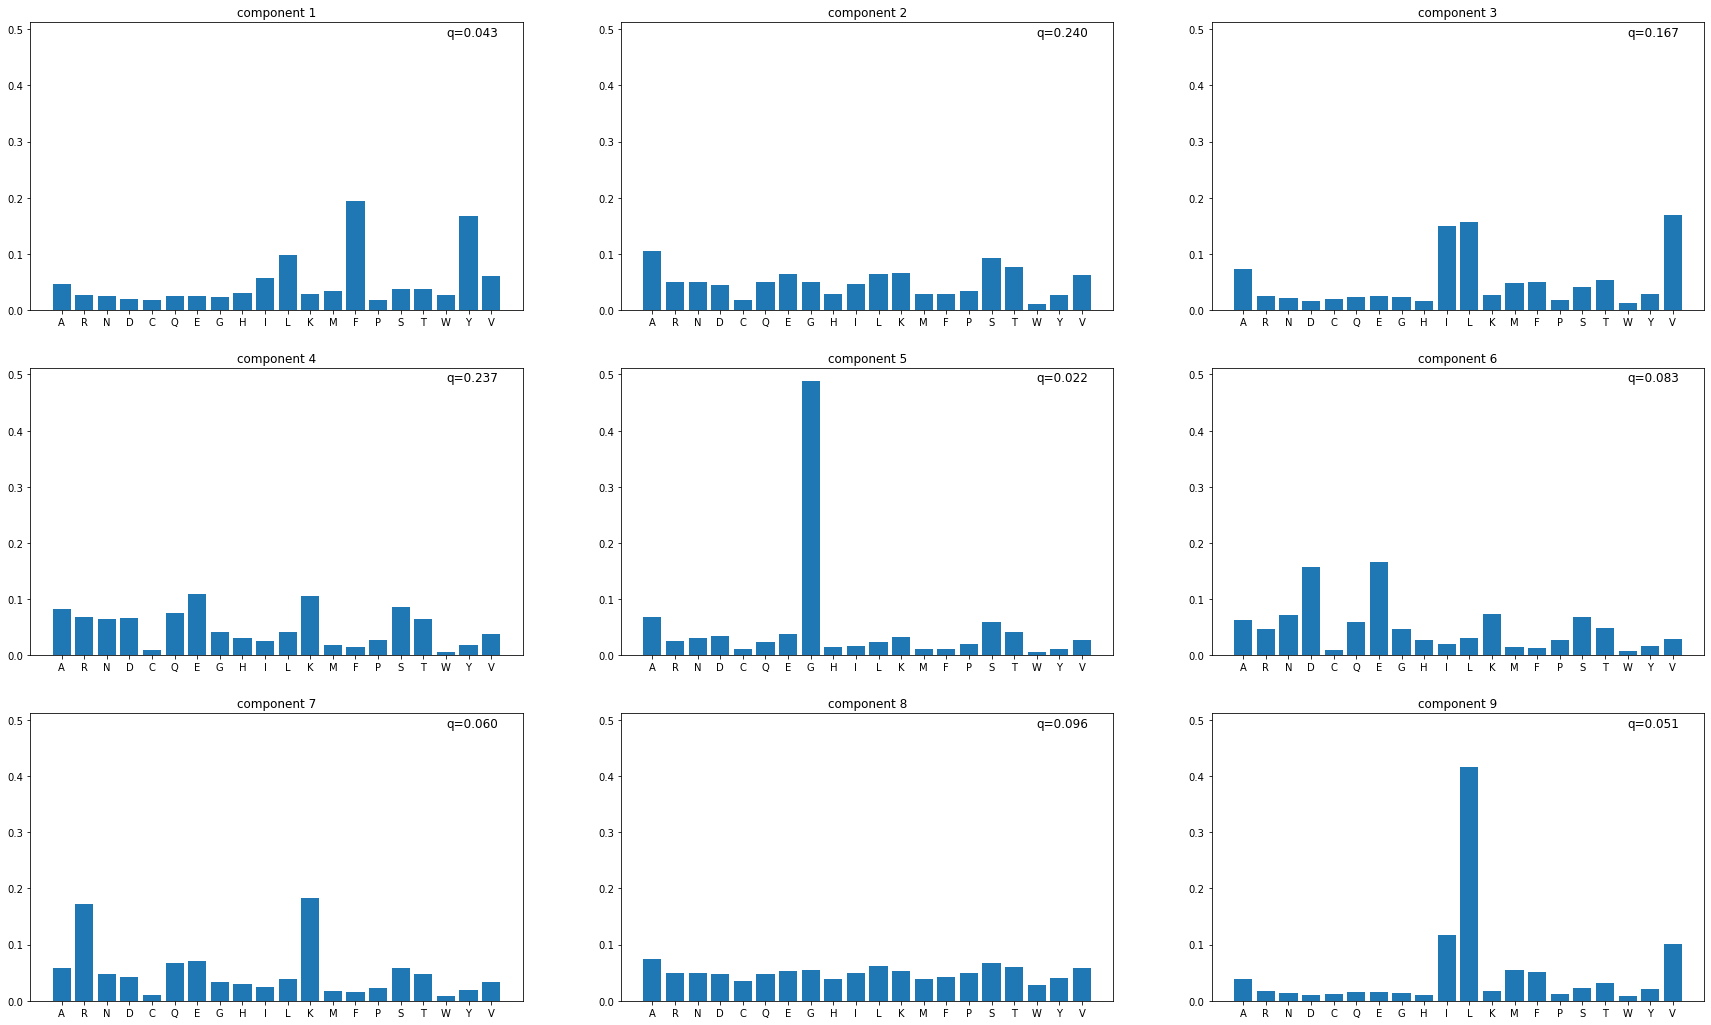

In [44]:
component_distributions = dirichlet_layer.component_distributions()
mix = dirichlet_layer.make_mix()
num_rows = num_cols = int(np.ceil(np.sqrt(num_components)))
plt.rcParams['figure.figsize'] = (10*num_rows, 6*num_cols)
fig, axes = plt.subplots(num_rows, num_cols)
axes = axes.flatten() if num_components > 1 else [axes]
max_prob = np.amax(component_distributions)
for i,ax in zip(range(num_components), axes):
    ax.set_ylim((0,max_prob*1.05))
    ax.bar(msa_hmm.fasta.alphabet[:20], component_distributions[i])
    ax.text(17, max_prob,"q="+str('%.3f' % mix[i].numpy()), fontsize=12)
    ax.set_title("component "+str(i+1))

In the plot above it can be seen, that the multimodal component distributions have amino acids that share biochemical properties. E.g. D and E are both negatively charged and polar. 

### A prior for the transitions

For every state type (e.g. match) there is a specific transition distribution to other states. In the edge cases some probabilities can be 0. We regularize these distributions with a dirichlet prior. Here we train such a prior again using Pfam and the HMM models it provides.

Specifically we estimate these dirichlet priors:
- for match states (MM, MI, MD)
- for insertion states (II, IM)
- for delete states (DD, DM)

Dirichlet priors for entry, exit, repeat and flaking states are manually chosen.

In [6]:
def train_transition_prior(name, 
                           train_dataset, 
                           test_dataset, 
                           num_runs = 5,
                           num_components = [1,2,3,5],
                           dtypes = [tf.float32, tf.float64],
                               batch_size = 512):
    for k,d in itertools.product(num_components, dtypes):
        models = []
        for _ in range(num_runs):
            dm_layer = msa_hmm.dm.DirichletMixtureLayer(num_components = k,
                                                        alphabet_size = train_dataset.shape[1],
                                                        use_dirichlet_process = False,
                                                        dtype = d)
            model = msa_hmm.dm.make_model(dm_layer)
            model.compile(tf.optimizers.Adam(1e-2))
            callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
            history = model.fit(train_dataset, epochs = 1000, verbose = 1, batch_size=batch_size, callbacks=[callback])
            loglik = tf.reduce_mean(model.predict(test_dataset, batch_size=batch_size)).numpy()
            models.append((loglik, model))
        best = max(models)[1]
        model_name = "_".join([name, str(k), d.name]) + "/ckpt"
        best.save_weights(prior_dir + "transition_priors/"+model_name)
        tf.keras.backend.clear_session()

In [ ]:
train_transition_prior("match_prior", match_dists_train, match_dists_test)

In [ ]:
train_transition_prior("insert_prior", insert_dists_train, insert_dists_test)

In [ ]:
train_transition_prior("delete_prior", delete_dists_train, delete_dists_test)

In [15]:
def summarize_prior(name = "match_prior", num_components = 2, dim=3, dtype = tf.float32):
    model_path = prior_dir + "transition_priors/" + "_".join([name, str(num_components), dtype.name, "/ckpt"])
    model = msa_hmm.dm.load_mixture_model(model_path, num_components, dim)
    dirichlet_layer = model.layers[-1]
    print(f"alpha({name})=\n", dirichlet_layer.make_alpha().numpy())
    print(f"mix({name})=\n", dirichlet_layer.make_mix().numpy())
    
summarize_prior("match_prior", num_components=2, dim=3)
summarize_prior("insert_prior", num_components=2, dim=2)
summarize_prior("delete_prior", num_components=2, dim=2)

alpha(match_prior)=
 [[5.3009667e+00 4.4679147e-01 4.1478762e-01]
 [4.7267957e+02 6.1485915e+00 3.2890594e+00]]
mix(match_prior)=
 [0.13333601 0.866664  ]
alpha(insert_prior)=
 [[1.5672164e+00 1.7381232e+00]
 [3.8279668e+04 3.2850250e+04]]
mix(insert_prior)=
 [0.05507373 0.9449262 ]
alpha(delete_prior)=
 [[1.9310432e+04 1.2077352e+04]
 [8.9107952e+00 7.2740235e+00]]
mix(delete_prior)=
 [0.78462243 0.21537758]
